68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training folders: ['dogs', 'cats']
Validation folders: ['dogs', 'cats']
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 14s/step - accuracy: 0.4000 - loss: 1.0605 - val_accuracy: 0.5250 - val_loss: 0.6147
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 13s/step - accuracy: 0.5333 - loss: 0.7123 - val_accuracy: 0.8000 - val_loss: 0.5398
Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 14s/step - accuracy: 0.9000 - loss: 0.5012 - val_accuracy: 0.6750 - val_loss: 0.5455
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 16s/step - accuracy: 0.7333 - loss: 0.5278 - val_accuracy: 0.8250 - val_loss: 0.5089


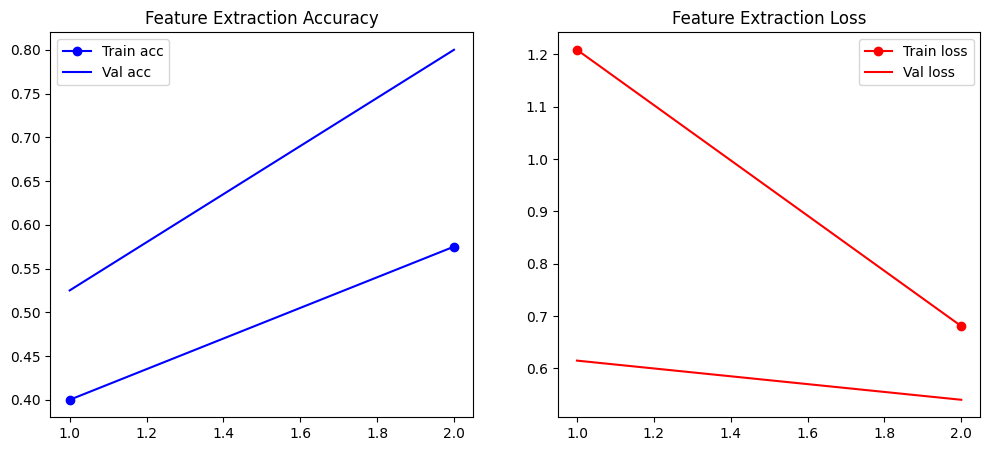

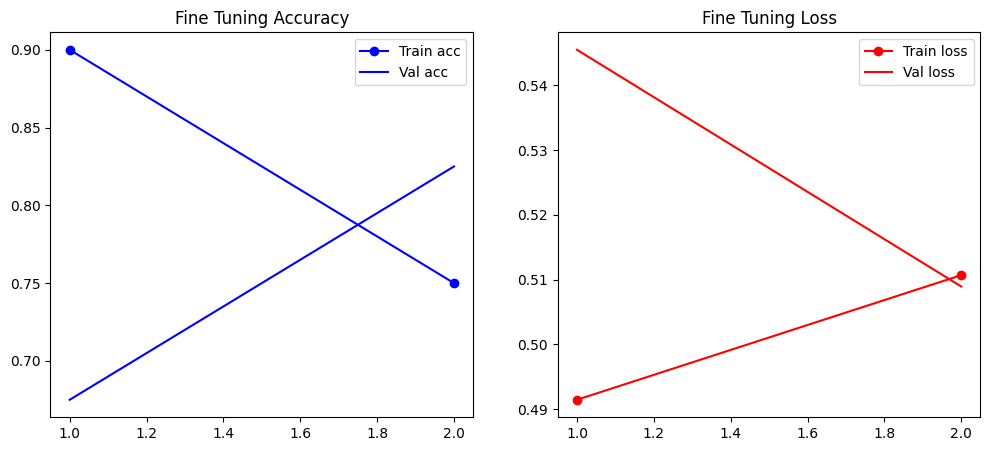

Model saved as vgg16_finetuned_model.h5


In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 1. Download and extract the dataset properly
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=False)

# Extract manually to a known path
extract_path = '/content/cats_and_dogs_filtered'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Define paths after extraction
base_dir = extract_path
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Check if directories exist now
print("Training folders:", os.listdir(train_dir))
print("Validation folders:", os.listdir(validation_dir))

# 2. Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# 3. Load VGG16 convolutional base
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
conv_base.trainable = False

# 4. Build model
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

# 5. Train model (feature extraction)
history = model.fit(
    train_generator,
    steps_per_epoch=2,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=2
)

# 6. Fine-tune last 4 conv layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=2,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=2
)

# 7. Plot function
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(acc)+1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo-', label='Train acc')
    plt.plot(epochs, val_acc, 'b-', label='Val acc')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'ro-', label='Train loss')
    plt.plot(epochs, val_loss, 'r-', label='Val loss')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

plot_history(history, 'Feature Extraction')
plot_history(history_fine, 'Fine Tuning')

# Save model
model.save('vgg16_finetuned_model.h5')
print("Model saved as vgg16_finetuned_model.h5")

Saving inputimg.jpeg to inputimg (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Prediction: Dog (0.55)


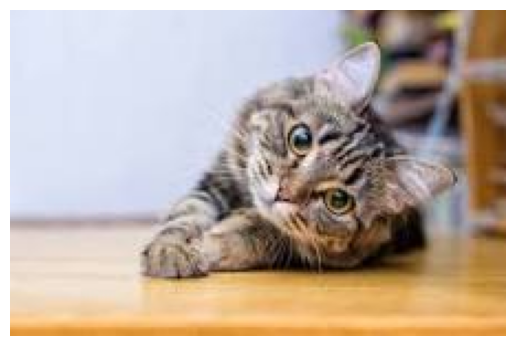

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
from PIL import Image

# Load the trained model
model = tf.keras.models.load_model('vgg16_finetuned_model.h5')

# Upload image from user
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(150, 150))  # Resize same as training
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0   # Normalize

    prediction = model.predict(img_array)

    # Classification
    if prediction[0] > 0.5:
        print(f"Prediction: Dog ({prediction[0][0]:.2f})")
    else:
        print(f"Prediction: Cat ({1 - prediction[0][0]:.2f})")

    # Show uploaded image
    plt.imshow(Image.open(img_path))
    plt.axis("off")
    plt.show()
